# Applying Machine Learning to Exoplanet Candidate Classification

### Data produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu

Data used for prediction model:
* koi_period:     Orbital Period [days]
* koi_time0bk:    Transit Epoch [BKJD]
* koi_impact:     Impact Parameter
* koi_duration:   Transit Duration [hrs]
* koi_depth:      Transit Depth [ppm]
* koi_prad:       Planetary Radius [Earth radii]
* koi_teq:        Equilibrium Temperature [K]
* koi_insol:      Insolation Flux [Earth flux]
* koi_model_snr:  Transit Signal-to-Noise
* koi_steff:      Stellar Effective Temperature [K]
* koi_slogg:      Stellar Surface Gravity [log10(cm/s**2)]
* koi_srad:       Stellar Radius [Solar radii]

In [1]:
#initialize machine learning tool H2O.ai
import h2o
%matplotlib inline
import pandas as pd
h2o.init(nthreads = 1, max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_131"; OpenJDK Runtime Environment (build 1.8.0_131-8u131-b11-0ubuntu1.16.04.2-b11); OpenJDK 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from /usr/local/lib/python2.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpQt2Cj9
  JVM stdout: /tmp/tmpQt2Cj9/h2o_root_started_from_python.out
  JVM stderr: /tmp/tmpQt2Cj9/h2o_root_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.10.4.8
H2O cluster version age:,1 month and 5 days
H2O cluster name:,H2O_from_python_root_rw2qhi
H2O cluster total nodes:,1
H2O cluster free memory:,7.111 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,1
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


## Training Data: Already Classified Exoplanets

Exoplanets that are already classified as "CONFIRMED" or "FALSE POSITIVES" are used to train the machine learning algorithm

In [2]:
exoplanets_csv = "data/exoplanet_results.csv"
data = h2o.import_file(exoplanets_csv)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
#Using classification as binary factor, outputs possible factors
data['koi_disposition'] = data['koi_disposition'].asfactor()
data['koi_disposition'].levels()

[['CONFIRMED', 'FALSE POSITIVE']]

We split the data into three sets - a training set, a validation set, and a testing set. The training set is used to actual train the model. The validation set is used to select the best model for the applicable data set. The test set is used to determine the accuracy of the model

In [4]:
splits = data.split_frame(ratios=[0.7, 0.15], seed=1)  

train = splits[0]
valid = splits[1]
test = splits[2]

In [5]:
#note that these sets are not even. h2oai uses a seed to maintain some variability
print train.nrow
print valid.nrow
print test.nrow

5150
1066
1100


In [6]:
y = 'koi_disposition'
x = list(data.columns)

In [7]:
#remove columns not used for prediction model
x.remove(y)  #remove the response
x.remove('rowid') 
x.remove('kepid')
x.remove('kepoi_name')
x.remove('kepler_name')

## First Model: Generalized Logistic Regression Model
We first run a test using one of the simplest machine learning method, the generalized linear model. Because this is a binary classification, we use a logistic regression as a classification method. This will give us a test case and some preliminary results. We can implement more advanced techniques later

In [8]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [9]:
#Simple GLM
glm_fit = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_fit')

In [10]:
glm_fit.train(x=x, y=y, training_frame=train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


### Testing Model with Test Set

In [11]:
glm_perf = glm_fit.model_performance(test)

In [12]:
print glm_perf.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.467997156851: 


,CONFIRMED,FALSE POSITIVE,Error,Rate
CONFIRMED,254.0,92.0,0.2659,(92.0/346.0)
FALSE POSITIVE,83.0,671.0,0.1101,(83.0/754.0)
Total,337.0,763.0,0.1591,(175.0/1100.0)


This confusion matrix gives the results of running this model on the test set we specified above. The columns represent the model predictions, while the rows represent the actual data. We see that this model can classify confirmed exoplanets 70-75% of the time, while it can classify False Positives ~90% of the time. Although these are rough estimates, they do give some indication to the performance of the model.

*Estimated Total Accuracy: 84.09%*

In [13]:
# Retreive test set AUC
print glm_perf.auc()

0.90631276736


AUC: The expected true positive rate if the ranking is split just before a uniformly drawn random negative. 

### Apply Prediction Model to Exoplanet Candidates

In [14]:
#import candidate data file
candidate_csv = "data/candidates.csv"
candidate_data = h2o.import_file(candidate_csv)


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [15]:
#run GLM
glm_predict = glm_fit.predict(candidate_data)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [16]:
glm_candidate_combine = candidate_data.cbind(glm_predict)
h2o.export_file(glm_candidate_combine, "data/glm_candidate_predict.csv")

Export File progress: |███████████████████████████████████████████████████| 100%


In [17]:
glm_candidate_predict_data = pd.read_csv('data/glm_candidate_predict.csv').sort_values('CONFIRMED')

#### Most likey to be false positives

In [18]:
pd.DataFrame(glm_candidate_predict_data, columns = ['kepid', 'predict','CONFIRMED','FALSE POSITIVE'])[0:10]

,kepid,predict,CONFIRMED,FALSE POSITIVE
1422,5131276,FALSE POSITIVE,0.000000e+00,1.0
1839,9790965,FALSE POSITIVE,0.000000e+00,1.0
1962,9025662,FALSE POSITIVE,0.000000e+00,1.0
32,10287723,FALSE POSITIVE,0.000000e+00,1.0
1266,6790592,FALSE POSITIVE,0.000000e+00,1.0
2120,5858919,FALSE POSITIVE,0.000000e+00,1.0
1563,10004772,FALSE POSITIVE,0.000000e+00,1.0
696,8505215,FALSE POSITIVE,1.509903e-14,1.0
1153,3757590,FALSE POSITIVE,1.843858e-12,1.0
124,11342550,FALSE POSITIVE,1.186429e-11,1.0


#### Most likely to be confirmed exoplanets

In [19]:
pd.DataFrame(glm_candidate_predict_data, columns = ['kepid', 'predict','CONFIRMED','FALSE POSITIVE'])[:-11:-1]

,kepid,predict,CONFIRMED,FALSE POSITIVE
1158,5384713,CONFIRMED,0.909577,0.090423
109,9427402,CONFIRMED,0.908379,0.091621
302,2161536,CONFIRMED,0.905637,0.094363
1511,10747162,CONFIRMED,0.905629,0.094371
1986,7868967,CONFIRMED,0.899582,0.100418
288,5601258,CONFIRMED,0.897332,0.102668
1994,10685764,CONFIRMED,0.895865,0.104135
1966,10813078,CONFIRMED,0.894170,0.105830
1063,8874090,CONFIRMED,0.893915,0.106085
2029,5289857,CONFIRMED,0.893061,0.106939


### Model 2: Random Forest Algorithm

In [20]:
# Import H2O RF:
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [21]:
rf_fit = H2ORandomForestEstimator(model_id='rf_fit', ntrees=500, seed=1)
rf_fit.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [22]:
rf_perf = rf_fit.model_performance(test)
rf_perf.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.500143638499: 


,CONFIRMED,FALSE POSITIVE,Error,Rate
CONFIRMED,302.0,44.0,0.1272,(44.0/346.0)
FALSE POSITIVE,41.0,713.0,0.0544,(41.0/754.0)
Total,343.0,757.0,0.0773,(85.0/1100.0)


*Estimated Accuracy: 92.27%*

In [23]:
# Retreive test set AUC
rf_perf.auc()

0.9763496419864768

### Apply Prediction Model to Exoplanet Candidates

In [24]:
rf_predict = rf_fit.predict(candidate_data)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [25]:
rf_candidate_combine = candidate_data.cbind(rf_predict)
h2o.export_file(rf_candidate_combine, "data/rf_candidate_predict.csv")

Export File progress: |███████████████████████████████████████████████████| 100%


In [26]:
rf_candidate_predict_data = pd.read_csv('data/rf_candidate_predict.csv').sort_values('CONFIRMED')

#### Most likey to be false positives

In [27]:
pd.DataFrame(rf_candidate_predict_data, columns = ['kepid', 'predict','CONFIRMED','FALSE POSITIVE'])[0:10]

,kepid,predict,CONFIRMED,FALSE POSITIVE
1544,9941136,FALSE POSITIVE,0.000000,1.000000
1606,12009917,FALSE POSITIVE,0.000000,1.000000
2168,5956171,FALSE POSITIVE,0.000023,0.999977
2155,5098334,FALSE POSITIVE,0.000094,0.999906
1146,5881307,FALSE POSITIVE,0.000094,0.999906
2003,8971044,FALSE POSITIVE,0.000094,0.999906
1694,11462969,FALSE POSITIVE,0.000411,0.999589
1414,3542928,FALSE POSITIVE,0.000411,0.999589
1487,10802364,FALSE POSITIVE,0.000411,0.999589
1493,8747910,FALSE POSITIVE,0.000411,0.999589


#### Most likely to be confirmed exoplanets

In [28]:
pd.DataFrame(rf_candidate_predict_data, columns = ['kepid', 'predict','CONFIRMED','FALSE POSITIVE'])[:-11:-1]

,kepid,predict,CONFIRMED,FALSE POSITIVE
684,10155434,CONFIRMED,0.980644,0.019356
7,3641726,CONFIRMED,0.979300,0.020700
105,8804283,CONFIRMED,0.978898,0.021102
669,5978361,CONFIRMED,0.977675,0.022325
1065,5965819,CONFIRMED,0.976665,0.023335
717,2444412,CONFIRMED,0.974097,0.025903
25,9347899,CONFIRMED,0.969880,0.030120
712,9266431,CONFIRMED,0.969454,0.030546
381,11852982,CONFIRMED,0.969068,0.030932
199,7386827,CONFIRMED,0.966017,0.033983


### Model 3: Gradient Boosting Machine

In [29]:
# Import H2O GBM:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [30]:
# Initialize and train the GBM estimator:

gbm_fit = H2OGradientBoostingEstimator(model_id='gbm_fit', ntrees=500, seed=1)
gbm_fit.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [31]:
gbm_perf = gbm_fit.model_performance(test)
gbm_perf.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.498293114556: 


,CONFIRMED,FALSE POSITIVE,Error,Rate
CONFIRMED,306.0,40.0,0.1156,(40.0/346.0)
FALSE POSITIVE,40.0,714.0,0.0531,(40.0/754.0)
Total,346.0,754.0,0.0727,(80.0/1100.0)


*Estimated Accuracy: 92.73%*

In [32]:
# Retreive test set AUC
gbm_perf.auc()

0.9785920179083425

### Apply Prediction Model to Exoplanet Candidates

In [33]:
gbm_predict = gbm_fit.predict(candidate_data)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [34]:
gbm_candidate_combine = candidate_data.cbind(gbm_predict)
h2o.export_file(gbm_candidate_combine, "data/gbm_candidate_predict.csv")

Export File progress: |███████████████████████████████████████████████████| 100%


In [35]:
gbm_candidate_predict_data = pd.read_csv('data/gbm_candidate_predict.csv').sort_values('CONFIRMED')

#### Most likey to be false positives

In [36]:
pd.DataFrame(gbm_candidate_predict_data, columns = ['kepid', 'predict','CONFIRMED','FALSE POSITIVE'])[0:10]

,kepid,predict,CONFIRMED,FALSE POSITIVE
1665,4255944,FALSE POSITIVE,1.575116e-07,1.000000
1850,5388229,FALSE POSITIVE,2.497384e-07,1.000000
1691,6032730,FALSE POSITIVE,4.635260e-07,1.000000
1798,11495989,FALSE POSITIVE,1.003039e-06,0.999999
1906,3634169,FALSE POSITIVE,1.091802e-06,0.999999
1567,9173014,FALSE POSITIVE,1.128606e-06,0.999999
2120,5858919,FALSE POSITIVE,1.148121e-06,0.999999
440,6199056,FALSE POSITIVE,1.206907e-06,0.999999
1286,9655129,FALSE POSITIVE,1.217450e-06,0.999999
2240,4548098,FALSE POSITIVE,1.232580e-06,0.999999


#### Most likely to be confirmed exoplanets

In [37]:
pd.DataFrame(gbm_candidate_predict_data, columns = ['kepid', 'predict','CONFIRMED','FALSE POSITIVE'])[:-11:-1]

,kepid,predict,CONFIRMED,FALSE POSITIVE
557,7700622,CONFIRMED,0.999689,0.000311
221,3448130,CONFIRMED,0.999666,0.000334
553,7364176,CONFIRMED,0.999625,0.000375
479,3425851,CONFIRMED,0.999517,0.000483
185,6049190,CONFIRMED,0.999478,0.000522
90,10928043,CONFIRMED,0.999438,0.000562
175,5972334,CONFIRMED,0.999421,0.000579
1571,7377343,CONFIRMED,0.999377,0.000623
261,7761918,CONFIRMED,0.999329,0.000671
464,7749773,CONFIRMED,0.999316,0.000684


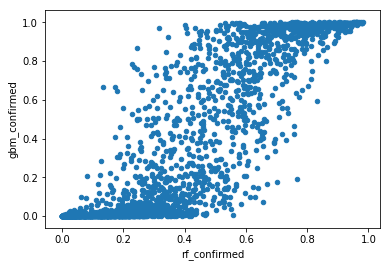

In [38]:
probCompare = pd.concat([rf_candidate_predict_data['CONFIRMED'], gbm_candidate_predict_data['CONFIRMED']], axis=1)
probCompare.columns = ['rf_confirmed','gbm_confirmed']
probCompare.plot(kind='scatter', x='rf_confirmed', y='gbm_confirmed')

Here, we see a scatterplot comparing the probabilites of CONFIRMED status for candidates, using the Random Forest model and the Gradient Boosted Method model. There is clearly a correlation between the two results.

In [39]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_9055 closed.


## Appendix

### Candidate Result CSV Downloads

[Logistic Regression Model](data/glm_candidate_predict.csv)

[Random Forest Model](data/rf_candidate_predict.csv)

[Gradient Boosted Machine](data/gbm_candidate_predict.csv)

[Summarized Table](data/summarized.csv)